# Time evolution

This tutorial guides you in the implementation of the iTEBD invented by Vidal in 2005. We will follow once more G. Evenbly implementation. 

Beside going to the canonical form (that we have already seen yesterday)
the core of the game is to apply a two body gate, and then go back to the the MPS caonical form. 

The two body gate represents a short evolution step as seen in class today.

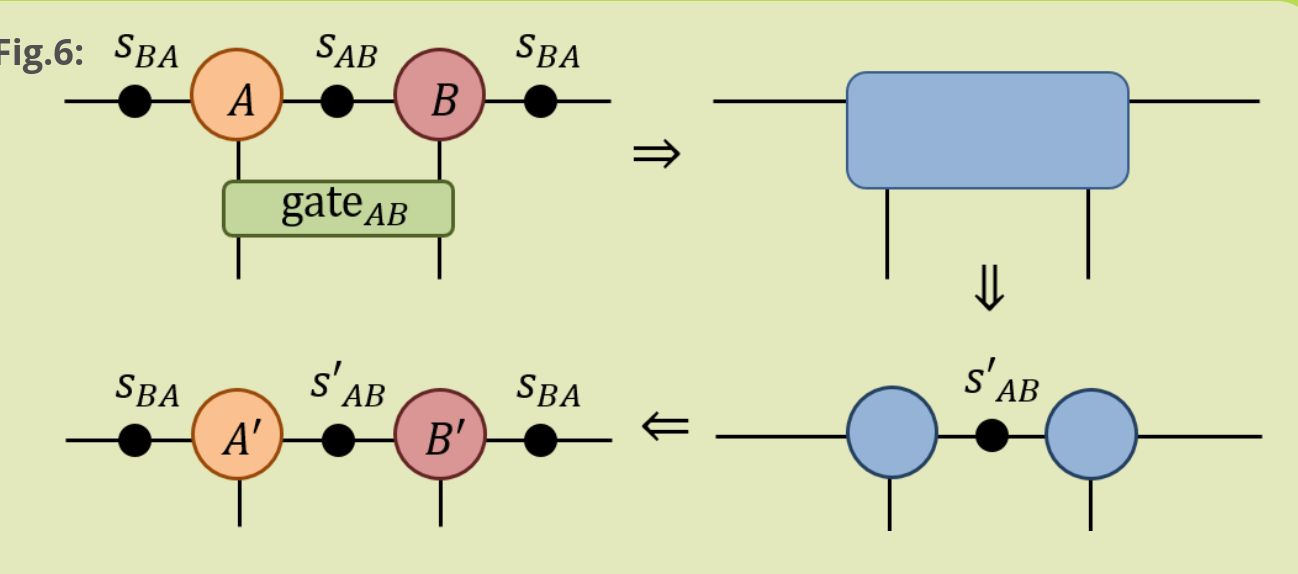

The MPS tensors are ordered left-center right

Assuming that the tensor network is in the canonical form the function that applies the gate is this

## Exercice 1
Complete the network contraction 

In [1]:
def apply_gate_MPS(gateAB, A, sAB, B, sBA, chi, stol=1e-7):
  """ apply a gate to an MPS across and a A-B link. Truncate the MPS back to
  some desired dimension chi"""

  # ensure singular values are above tolerance threshold
  sBA_trim = sBA * (sBA > stol) + stol * (sBA < stol)

  # contract gate into the MPS, then deompose composite tensor with SVD
  d = A.shape[1]
  chiBA = sBA_trim.shape[0]
  tensors = [np.diag(sBA_trim), A, np.diag(sAB), B, np.diag(sBA_trim), gateAB]
  connects = [[-1, 1], [1, 5, 2], [2, 4], [4, 6, 3], [3, -4], [-2, -3, 5, 6]]
  nshape = [d * chiBA, d * chiBA]
  utemp, stemp, vhtemp = LA.svd(ncon(tensors, connects).reshape(nshape),
                                full_matrices=False)

  # truncate to reduced dimension
  chitemp = min(chi, len(stemp))
  utemp = utemp[:, range(chitemp)].reshape(sBA_trim.shape[0], d * chitemp)
  vhtemp = vhtemp[range(chitemp), :].reshape(chitemp * d, chiBA)

  # remove environment weights to form new MPS tensors A and B
  A = (np.diag(1 / sBA_trim) @ utemp).reshape(sBA_trim.shape[0], d, chitemp)
  B = (vhtemp @ np.diag(1 / sBA_trim)).reshape(chitemp, d, chiBA)

  # new weights
  sAB = stemp[range(chitemp)] / LA.norm(stemp[range(chitemp)])

  return A, sAB, B

All two sites operators can be evaluated by taking the trace with two body reduced density matrices, we thus write a function to compute those
## Exercice 2 
Complete the empty line of this function

In [2]:
def loc_density_MPS(A, sAB, B, sBA):
  """ Compute the local reduced density matrices from an MPS (assumend to be
  in canonical form)."""

  # recast singular weights into a matrix
  mAB = np.diag(sAB)
  mBA = np.diag(sBA)

  # contract MPS for local reduced density matrix (A-B)
  tensors = [np.diag(sBA**2), A, A.conj(), mAB, mAB, B, B.conj(),
             np.diag(sBA**2)]
  connects = [[3, 4], [3, -3, 1], [4, -1, 2], [1, 7], [2, 8], [7, -4, 5],
              [8, -2, 6], [5, 6]]
  rhoAB = ncon(tensors, connects)

  # contract MPS for local reduced density matrix (B-A)
  tensors = [np.diag(sAB**2), B, B.conj(), mBA, mBA, A, A.conj(),
             np.diag(sAB**2)]
  connects = [[3, 4], [3, -3, 1], [4, -1, 2], [1, 7], [2, 8], [7, -4, 5],
              [8, -2, 6], [5, 6]]
  rhoBA = ncon(tensors, connects)

  return rhoAB, rhoBA


Now we can put all toghether to simulate a quench for the Ising model from a product state with the critical Hamiltonian ($\lambda =\infty \to \lambda=0$)
## Exercice 3 
Modify the functions from G. Evenbly webpage,  such  that it
1. perform the quench discussed
2. returns a list of interesting quantities :energies magnetization and entanglement spectrum (as a function of time)
3. disable orthogonalization (we are using unitary gates)

In [3]:
  
# doTEBD.py
# ---------------------------------------------------------------------
# Implementation of time evolution (real or imaginary) for MPS with 2-site unit
# cell (A-B), based on TEBD algorithm.
#freely hacked by LT from the original version 
# by Glen Evenbly (c) for www.tensors.net, (v1.2) - last modified 6/2019

import numpy as np
from numpy import linalg as LA
from scipy.linalg import expm
from scipy.sparse.linalg import LinearOperator, eigs
from ncon import ncon
from typing import Optional


def doTEBD(hamAB: np.ndarray,
           hamBA: np.ndarray,
           A: np.ndarray,
           B: np.ndarray,
           sAB: np.ndarray,
           sBA: np.ndarray,
           chi: int,
           tau: float,
           evotype: Optional[str] = 'imag',
           numiter: Optional[int] = 1000,
           midsteps: Optional[int] = 10,
           E0: Optional[float] = 0.0):
  """
  Implementation of time evolution (real or imaginary) for MPS with 2-site unit
  cell (A-B), based on TEBD algorithm.
  Args:
    hamAB: nearest neighbor Hamiltonian coupling for A-B sites.
    hamBA: nearest neighbor Hamiltonian coupling for B-A sites.
    A: MPS tensor for A-sites of lattice.
    B: MPS tensor for B-sites of lattice.
    sAB: vector of weights for A-B links.
    sBA: vector of weights for B-A links.
    chi: maximum bond dimension of MPS.
    tau: time-step of evolution.
    evotype: set real (evotype='real') or imaginary (evotype='imag') evolution.
    numiter: number of time-step iterations to take.
    midsteps: number of time-steps between re-orthogonalization of the MPS.
    E0: specify the ground energy (if known).
  Returns:
    np.ndarray: MPS tensor for A-sites;
    np.ndarray: MPS tensor for B-sites;
    np.ndarray: vector sAB of weights for A-B links.
    np.ndarray: vector sBA of weights for B-A links.
    np.ndarray: two-site reduced density matrix rhoAB for A-B sites
    np.ndarray: two-site reduced density matrix rhoAB for B-A sites
  """

  # exponentiate Hamiltonian
  d = A.shape[1]
  if evotype == "real":
    gateAB = expm(1j * tau * hamAB.reshape(d**2, d**2)).reshape(d, d, d, d)
    gateBA = expm(1j * tau * hamBA.reshape(d**2, d**2)).reshape(d, d, d, d)
  elif evotype == "imag":
    gateAB = expm(-tau * hamAB.reshape(d**2, d**2)).reshape(d, d, d, d)
    gateBA = expm(-tau * hamBA.reshape(d**2, d**2)).reshape(d, d, d, d)

  # initialize environment matrices
  sigBA = np.eye(A.shape[0]) / A.shape[0]
  muAB = np.eye(A.shape[2]) / A.shape[2]
  mag_AB =0.5*(np.kron(sZ,np.eye(2))+
               np.kron(np.eye(2),sZ)).reshape(d,d,d,d)
  list_energy =[]
  list_sAB =[]
  list_mag=[]
  for k in range(numiter + 1):
    """ Do evolution of MPS through one time-step """
    if k < numiter:
      # apply gate to A-B link
      A, sAB, B = apply_gate_MPS(gateAB, A, sAB, B, sBA, chi)

      # apply gate to B-A link
      B, sBA, A = apply_gate_MPS(gateBA, B, sBA, A, sAB, chi)
      list_sAB.append(sAB)
    # compute 2-site local reduced density matrices
      rhoAB, rhoBA = loc_density_MPS(A, sAB, B, sBA)

      # evaluate the energy
      energyAB = ncon([hamAB, rhoAB], [[1, 2, 3, 4], [1, 2, 3, 4]])
      energyBA = ncon([hamBA, rhoBA], [[1, 2, 3, 4], [1, 2, 3, 4]])
      v_mag_AB = ncon([mag_AB, rhoAB], [[1, 2, 3, 4], [1, 2, 3, 4]])
      energy = 0.5 * (energyAB + energyBA)
      list_energy.append(energy)
      list_mag.append(v_mag_AB)
  rhoAB, rhoBA = loc_density_MPS(A, sAB, B, sBA)
  return (A, B, sAB, sBA, rhoAB, rhoBA, 
        list_energy,list_sAB,list_mag)




def apply_gate_MPS(gateAB, A, sAB, B, sBA, chi, stol=1e-7):
  """ apply a gate to an MPS across and a A-B link. Truncate the MPS back to
  some desired dimension chi"""

  # ensure singular values are above tolerance threshold
  sBA_trim = sBA * (sBA > stol) + stol * (sBA < stol)

  # contract gate into the MPS, then deompose composite tensor with SVD
  d = A.shape[1]
  chiBA = sBA_trim.shape[0]
  tensors = [np.diag(sBA_trim), A, np.diag(sAB), B, np.diag(sBA_trim), gateAB]
  connects = [[-1, 1], [1, 5, 2], [2, 4], [4, 6, 3], [3, -4], [-2, -3, 5, 6]]
  nshape = [d * chiBA, d * chiBA]
  utemp, stemp, vhtemp = LA.svd(ncon(tensors, connects).reshape(nshape),
                                full_matrices=False)

  # truncate to reduced dimension
  chitemp = min(chi, len(stemp))
  utemp = utemp[:, range(chitemp)].reshape(sBA_trim.shape[0], d * chitemp)
  vhtemp = vhtemp[range(chitemp), :].reshape(chitemp * d, chiBA)

  # remove environment weights to form new MPS tensors A and B
  A = (np.diag(1 / sBA_trim) @ utemp).reshape(sBA_trim.shape[0], d, chitemp)
  B = (vhtemp @ np.diag(1 / sBA_trim)).reshape(chitemp, d, chiBA)

  # new weights
  sAB = stemp[range(chitemp)] / LA.norm(stemp[range(chitemp)])

  return A, sAB, B


def loc_density_MPS(A, sAB, B, sBA):
  """ Compute the local reduced density matrices from an MPS (assumend to be
  in canonical form)."""

  # recast singular weights into a matrix
  mAB = np.diag(sAB)
  mBA = np.diag(sBA)

  # contract MPS for local reduced density matrix (A-B)
  tensors = [np.diag(sBA**2), A, A.conj(), mAB, mAB, B, B.conj(),
             np.diag(sBA**2)]
  connects = [[3, 4], [3, -3, 1], [4, -1, 2], [1, 7], [2, 8], [7, -4, 5],
              [8, -2, 6], [5, 6]]
  rhoAB = ncon(tensors, connects)

  # contract MPS for local reduced density matrix (B-A)
  tensors = [np.diag(sAB**2), B, B.conj(), mBA, mBA, A, A.conj(),
             np.diag(sAB**2)]
  connects = [[3, 4], [3, -3, 1], [4, -1, 2], [1, 7], [2, 8], [7, -4, 5],
              [8, -2, 6], [5, 6]]
  rhoBA = ncon(tensors, connects)

  return rhoAB, rhoBA


## All together

In [9]:
# Implementation of time evolution (real or imaginary) for MPS with 2-site unit
# cell (A-B), based on TEBD algorithm.
#
# by Glen Evenbly (c) for www.tensors.net, (v1.2) - last modified 6/2019
""" Example 1: Ising model """

# set bond dimensions and simulation options
chi = 300 # bond dimension
tau = 0.01  # timestep
v_lambda=1.
numiter = 500 # number of timesteps
evotype = "real"  # real or imaginary time evolution
midsteps = 1000  # timesteps between MPS re-orthogonalization

# define Hamiltonian (Ising model)
sX = np.array([[0, 1], [1, 0]])

sZ = np.array([[1, 0], [0, -1]])
hamAB = (np.real(np.kron(sX, sX)) +v_lambda*0.5*(
            np.real(np.kron(sZ, np.eye(2))
                    +np.kron(np.eye(2),sZ)))).reshape(2, 2, 2, 2)
hamBA = (np.real(np.kron(sX, sX)) +v_lambda*0.5*(
            np.real(np.kron(sZ, np.eye(2))
                    +np.kron(np.eye(2),sZ)))).reshape(2, 2, 2, 2)

# initialize tensors
d = hamAB.shape[0]
sAB = np.ones(d) / np.sqrt(d)
sBA = np.ones(d) / np.sqrt(d)
A = np.zeros([d, d, d])
B = np.zeros([d, d, d])

A[0,0,0]=1.
B[0,0,0]=1.

""" Real time evolution with TEBD """
# run TEBD routine
[A, B, sAB, sBA, rhoAB, 
    rhoBA,list_ene,list_ent_spe,list_mag] =doTEBD(hamAB, hamBA, A, B, sAB, sBA, chi,
    tau, evotype=evotype, numiter=numiter, midsteps=midsteps)


# continute running TEBD routine with reduced timestep and increased bond dim

# compare with exact results
energyMPS = np.real(0.5 * ncon([hamAB, rhoAB], [[1, 2, 3, 4], [1, 2, 3, 4]]) +
                    0.5 * ncon([hamBA, rhoBA], [[1, 2, 3, 4], [1, 2, 3, 4]]))

print('Final results => Bond dim: %d, Energy: %f' %
      (chi, energyMPS))


Final results => Bond dim: 300, Energy: 0.999960


## Exercice 4

Produce the plots of the 
1. Energy error as a function of the time
2. Entropy growth
3. First ten values of the entanglement spectrum ($-2\log(s_i)$)
4. The magnetization

and interpret the results

/tmp/ipykernel_123905/4216864979.py:8: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(ten_levels).T)


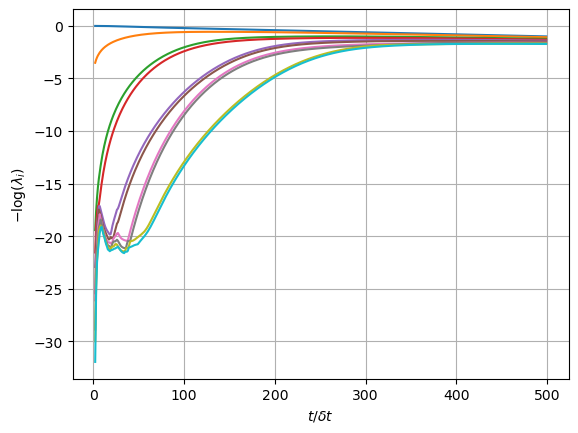

In [10]:
import matplotlib.pyplot as plt
num=10
ten_levels=np.zeros([num,len(list_ent_spe)])
for k in range(2,len(list_ent_spe)):
  ten_levels[:,k] = list_ent_spe[k][:num]


plt.plot(np.log(ten_levels).T)
plt.xlabel(r'$t/\delta t$')
plt.ylabel(r'$-\log(\lambda_i)$')
plt.grid()

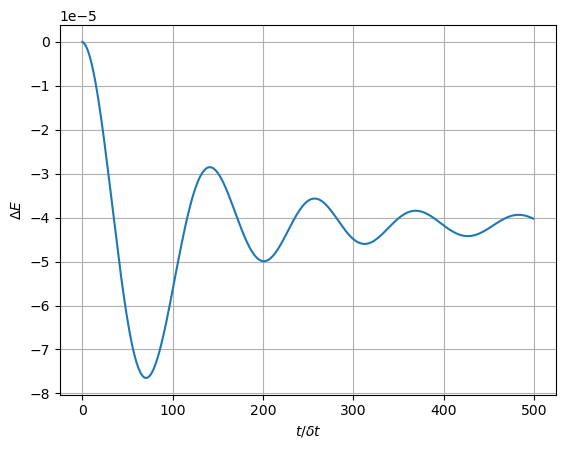

In [11]:
plt.plot(range(len(list_ene)),list_ene-list_ene[0])
plt.xlabel(r'$t/\delta t$')
plt.ylabel(r'$\Delta E$')
plt.grid()

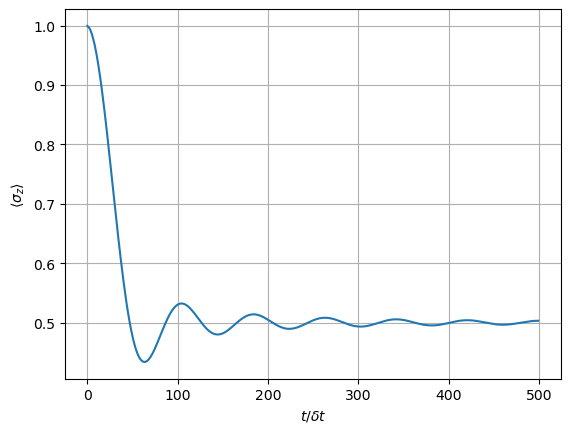

In [12]:
plt.plot(range(len(list_ene)),list_mag)
plt.xlabel(r'$t/\delta t$')
plt.ylabel(r'$\langle \sigma_z \rangle$')
plt.grid()

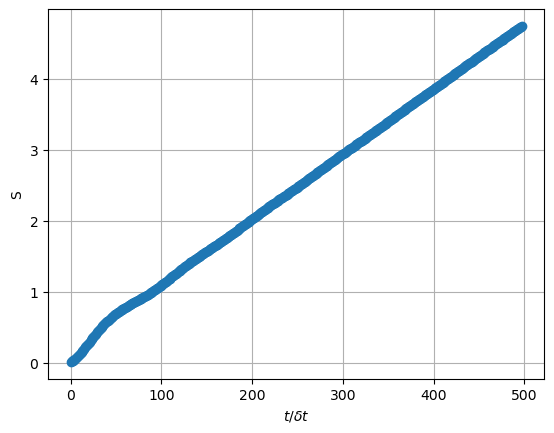

In [13]:
list_entropy=[]
for k in range(2,len(list_ent_spe)):
    number =sum(list_ent_spe[k]>1.e-10)
    ent_spe =np.array(list_ent_spe[k][:number])
    #print(ent_spe)
    list_entropy.append(-np.dot(ent_spe**2,np.log(ent_spe**2)
                          )/np.log(2))
    
plt.plot(range(len(list_entropy)),list_entropy,'o-')
plt.xlabel(r'$t/\delta t$')
plt.ylabel('S')
plt.grid()
